In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
#!pip install pyLDAvis

In [5]:
#!pip install sumy

In [6]:
import spacy.cli
spacy.cli.download("en_core_web_sm")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [79]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import os

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Enable Text Summarizers
from sumy.parsers.plaintext import PlaintextParser
from sumy.parsers.html import HtmlParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer

import gensim, operator
from scipy import spatial
import numpy as np
from gensim.models import KeyedVectors

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
# Import Dataset
df = pd.read_json('deduplicated_newsfeeds.json', lines = True)
print(df.title.unique())
df.head()

['Amarin (NASDAQ:AMRN) Rating Lowered to Strong Sell at BidaskClub'
 'Hess (NYSE:HES) Getting Positive Press Coverage, Analysis Finds'
 'Standard Chartered PLC to Post FY2022 Earnings of $1.02 Per Share, Jefferies Financial Group Forecasts (OTCMKTS:SCBFF)'
 ...
 'Royal Bank of Canada Raises Precision Drilling (TSE:PD) Price Target to C$1.25'
 'Citigroup Trims Suncor Energy (TSE:SU) Target Price to C$28.00'
 'Xerox Corp (NYSE:XRX) Up 6.6% in April']


,thread,uuid,url,ord_in_thread,parent_url,author,published,title,text,highlightText,highlightTitle,highlightThreadTitle,language,external_links,external_images,entities,rating,crawled
0,{'uuid': '6967779e14e58b9b3fda37192307027d4f6d...,6967779e14e58b9b3fda37192307027d4f6d62f5,http://omgili.com/ri/.wHSUbtEfZTYYn20f_iUpX442...,0,NaN,Kim Weber,2020-06-03T09:04:00.000+03:00,Amarin (NASDAQ:AMRN) Rating Lowered to Strong ...,Amarin (NASDAQ:AMRN) Rating Lowered to Strong ...,,,,english,"[http://bidaskclub.com, http://www.bidaskclub....",[],"{'persons': [{'name': 'kim weber', 'sentiment'...",NaN,2020-06-03T09:46:02.000+03:00
1,{'uuid': 'd6f56d2a07a4b5704f1a7223097cf3f6b68a...,d6f56d2a07a4b5704f1a7223097cf3f6b68a1282,http://omgili.com/ri/.wHSUbtEfZQ5vy3q3jf4pUXuk...,0,NaN,ABMN Staff,2020-06-03T09:02:00.000+03:00,Hess (NYSE:HES) Getting Positive Press Coverag...,Hess surges after second upgrade in two days –...,,,,english,[https://sec.gov/Archives/edgar/data/4447/0001...,[],"{'persons': [{'name': 'hess', 'sentiment': 'no...",NaN,2020-06-03T09:41:50.000+03:00
2,{'uuid': '01847ffdf41e5f9d13ed1cba1700a1b200b9...,01847ffdf41e5f9d13ed1cba1700a1b200b967f1,http://omgili.com/ri/.wHSUbtEfZTJB0lrIiBsKqDUC...,0,NaN,Alphonse Anthony,2020-06-03T09:02:00.000+03:00,Standard Chartered PLC to Post FY2022 Earnings...,Standard Chartered PLC (OTCMKTS:SCBFF) – Equit...,,,,english,[http://americanconsumernews.net/scripts/click...,[],"{'persons': [{'name': 'j. dickerson', 'sentime...",NaN,2020-06-03T10:02:29.005+03:00
3,{'uuid': '2f8dd67155c921611f8814b237dbb18e0543...,2f8dd67155c921611f8814b237dbb18e0543726c,http://omgili.com/ri/.wHSUbtEfZQ5vy3q3jf4pUXuk...,0,NaN,ABMN Staff,2020-06-03T08:56:00.000+03:00,Apergy Target of Unusually High Options Tradin...,Apergy Corp (NYSE:APY) saw some unusual option...,,,,english,[https://www.marketbeat.com/stocks/NYSE/APY/op...,[],"{'persons': [{'name': 'piper sandler', 'sentim...",NaN,2020-06-03T09:43:33.003+03:00
4,{'uuid': 'a4da6a28935dccbfd985b8ab7875dc67be90...,a4da6a28935dccbfd985b8ab7875dc67be90c7e6,http://omgili.com/ri/.wHSUbtEfZTYYn20f_iUpX442...,0,NaN,Kim Weber,2020-06-03T08:50:00.000+03:00,WPP (LON:WPP) Stock Rating Reaffirmed by Citig...,WPP (LON:WPP) Stock Rating Reaffirmed by Citig...,,,,english,[http://www.g.gituy.com/cgi/r?;n=203;c=1626483...,[],"{'persons': [{'name': 'kim weber', 'sentiment'...",NaN,2020-06-03T09:46:12.012+03:00


In [10]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Amarin (NASDAQ:AMRN) Rating Lowered to Strong Sell at BidaskClub Posted by '
 'Kim Weber on Jun 3rd, 2020 // Comments off BidaskClub downgraded shares of '
 'Amarin (NASDAQ:AMRN) from a sell rating to a strong sell rating in a report '
 'released on Saturday, BidAskClub reports. Other research analysts also '
 'recently issued research reports about the company. Citigroup boosted their '
 'target price on Amarin from $6.00 to $12.00 and gave the stock a buy rating '
 'in a research note on Friday, May 1st. SVB Leerink boosted their target '
 'price on Amarin from $7.00 to $9.00 and gave the stock an outperform rating '
 'in a research note on Monday, May 4th. Aegis boosted their target price on '
 'Amarin from $9.00 to $11.00 and gave the stock a buy rating in a research '
 'note on Monday, May 4th. Goldman Sachs Group downgraded Amarin from a buy '
 'rating to a neutral rating and lowered their target price for the stock from '
 '$27.00 to $4.00 in a research note on Tuesday, March 

In [11]:
# Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['amarin', 'nasdaq', 'amrn', 'rating', 'lowered', 'to', 'strong', 'sell', 'at', 'bidaskclub', 'posted', 'by', 'kim', 'weber', 'on', 'jun', 'rd', 'comments', 'off', 'bidaskclub', 'downgraded', 'shares', 'of', 'amarin', 'nasdaq', 'amrn', 'from', 'sell', 'rating', 'to', 'strong', 'sell', 'rating', 'in', 'report', 'released', 'on', 'saturday', 'bidaskclub', 'reports', 'other', 'research', 'analysts', 'also', 'recently', 'issued', 'research', 'reports', 'about', 'the', 'company', 'citigroup', 'boosted', 'their', 'target', 'price', 'on', 'amarin', 'from', 'to', 'and', 'gave', 'the', 'stock', 'buy', 'rating', 'in', 'research', 'note', 'on', 'friday', 'may', 'st', 'svb', 'leerink', 'boosted', 'their', 'target', 'price', 'on', 'amarin', 'from', 'to', 'and', 'gave', 'the', 'stock', 'an', 'outperform', 'rating', 'in', 'research', 'note', 'on', 'monday', 'may', 'th', 'aegis', 'boosted', 'their', 'target', 'price', 'on', 'amarin', 'from', 'to', 'and', 'gave', 'the', 'stock', 'buy', 'rating', 'in',

In [12]:
# Creating Bigram and Trigram Models
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['amarin', 'nasdaq', 'amrn', 'rating', 'lowered', 'to', 'strong', 'sell', 'at', 'bidaskclub', 'posted', 'by', 'kim_weber', 'on', 'jun', 'rd', 'comments_off', 'bidaskclub', 'downgraded', 'shares', 'of', 'amarin', 'nasdaq', 'amrn', 'from', 'sell', 'rating', 'to', 'strong', 'sell', 'rating', 'in', 'report', 'released', 'on', 'saturday', 'bidaskclub', 'reports', 'other', 'research', 'analysts', 'also', 'recently', 'issued', 'research', 'reports', 'about', 'the', 'company', 'citigroup', 'boosted', 'their', 'target', 'price', 'on', 'amarin', 'from', 'to', 'and', 'gave', 'the', 'stock', 'buy', 'rating', 'in', 'research', 'note', 'on', 'friday', 'may', 'st', 'svb_leerink', 'boosted', 'their', 'target', 'price', 'on', 'amarin', 'from', 'to', 'and', 'gave', 'the', 'stock', 'an', 'outperform', 'rating', 'in', 'research', 'note', 'on', 'monday', 'may', 'th', 'aegis', 'boosted', 'their', 'target', 'price', 'on', 'amarin', 'from', 'to', 'and', 'gave', 'the', 'stock', 'buy', 'rating', 'in', 'research

In [13]:
# Remove Stopwords, Make Bigrams and Lemmatize
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['rating', 'lower', 'strong', 'sell', 'bidaskclub', 'post', 'comment', 'bidaskclub', 'downgrade', 'share', 'sell', 'rating', 'strong', 'sell', 'rating', 'report', 'release', 'report', 'research', 'analyst', 'also', 'recently', 'issue', 'research', 'report', 'company', 'citigroup', 'boost', 'target', 'price', 'amarin', 'give', 'stock', 'buy', 'rating', 'research', 'note', 'svb_leerink', 'boost', 'target', 'price', 'amarin', 'give', 'stock', 'outperform', 'rating', 'research', 'note', 'aegis', 'boost', 'target', 'price', 'amarin', 'give', 'stock', 'buy', 'rating', 'research', 'note', 'group', 'downgrade', 'amarin', 'buy', 'rate', 'neutral', 'rating', 'lower', 'target', 'price', 'stock', 'research', 'note', 'finally', 'hc_wainwright', 'reissue', 'buy', 'rating', 'share', 'note', 'research', 'analyst', 'rate', 'stock', 'sell', 'rating', 'give', 'hold', 'rating', 'give', 'buy', 'rating', 'company', 'company', 'currently', 'consensus', 'rating', 'buy', 'consensus', 'price', 'target', 'get',

In [15]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 5), (3, 1), (4, 1), (5, 1), (6, 14), (7, 1), (8, 5), (9, 1), (10, 2), (11, 1), (12, 2), (13, 3), (14, 3), (15, 6), (16, 1), (17, 1), (18, 1), (19, 1), (20, 12), (21, 2), (22, 3), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 2), (31, 2), (32, 4), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 5), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 5), (52, 1), (53, 2), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 4), (60, 1), (61, 2), (62, 1), (63, 2), (64, 2), (65, 2), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 5), (72, 1), (73, 1), (74, 1), (75, 6), (76, 2), (77, 5), (78, 5), (79, 4), (80, 1), (81, 6), (82, 1), (83, 1), (84, 1), (85, 5), (86, 7), (87, 1), (88, 2), (89, 14), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 4), (98, 7), (99, 1), (100, 2), (101, 1), (102, 5), (103, 14), (104, 1), (105, 2), (106, 1), (107, 12), (108, 2), (109, 1), (11

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('acid', 1),
  ('add', 1),
  ('additional', 5),
  ('aegis', 1),
  ('alert', 1),
  ('also', 1),
  ('amarin', 14),
  ('amrn', 1),
  ('analyst', 5),
  ('anticipate', 1),
  ('average', 2),
  ('benefit', 1),
  ('bidaskclub', 2),
  ('boost', 3),
  ('business', 3),
  ('buy', 6),
  ('capitalization', 1),
  ('cardiovascular', 1),
  ('citigroup', 1),
  ('comment', 1),
  ('company', 12),
  ('compare', 2),
  ('consensus', 3),
  ('counselor', 2),
  ('current', 1),
  ('currently', 1),
  ('daily', 1),
  ('datum', 1),
  ('day', 2),
  ('develop', 1),
  ('development', 2),
  ('downgrade', 2),
  ('earning', 4),
  ('email', 1),
  ('equity', 1),
  ('estate', 2),
  ('estimate', 1),
  ('expectation', 1),
  ('experience', 1),
  ('finally', 2),
  ('fiscal', 1),
  ('focus', 1),
  ('fund', 1),
  ('get', 1),
  ('give', 5),
  ('group', 1),
  ('hc_wainwright', 1),
  ('health', 1),
  ('hedge', 1),
  ('high', 1),
  ('hold', 1),
  ('increase', 5),
  ('institutional', 1),
  ('investor', 2),
  ('issue', 1),
  ('large'

In [17]:
# Building the Topic Model

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
# View the topics in LDA model
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.049*"share" + 0.040*"company" + 0.038*"rating" + 0.034*"stock" + '
  '0.026*"quarter" + 0.023*"buy" + 0.022*"price" + 0.020*"research" + '
  '0.020*"report" + 0.020*"pharmaceutical"'),
 (1,
  '0.055*"share" + 0.041*"company" + 0.038*"stock" + 0.032*"rating" + '
  '0.031*"quarter" + 0.025*"price" + 0.018*"buy" + 0.017*"report" + '
  '0.015*"own" + 0.015*"average"'),
 (2,
  '0.058*"rating" + 0.033*"company" + 0.031*"share" + 0.030*"price" + '
  '0.029*"stock" + 0.026*"report" + 0.024*"research" + 0.023*"buy" + '
  '0.019*"average" + 0.018*"target"'),
 (3,
  '0.009*"market" + 0.008*"say" + 0.007*"year" + 0.007*"see" + 0.006*"bank" + '
  '0.006*"business" + 0.006*"first" + 0.005*"go" + 0.005*"time" + '
  '0.005*"financial"'),
 (4,
  '0.047*"share" + 0.031*"rating" + 0.030*"stock" + 0.029*"quarter" + '
  '0.028*"company" + 0.019*"dividend" + 0.019*"price" + 0.016*"ratio" + '
  '0.015*"report" + 0.015*"buy"')]


In [19]:
# Compute Model Perplexity and Coherence Score

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.799809285029782

Coherence Score:  0.4425311054235091


In [20]:
# Visualize the topics-keywords

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.091120  0.031695       1        1  47.135877
4      0.085758  0.058677       2        1  22.527443
2      0.086227 -0.151444       3        1  15.940725
3     -0.388177  0.004871       4        1   7.504244
0      0.125073  0.056200       5        1   6.891710, topic_info=        Term           Freq          Total Category  logprob  loglift
89    rating   91180.000000   91180.000000  Default  30.0000  30.0000
103    share  121239.000000  121239.000000  Default  29.0000  29.0000
86   quarter   62755.000000   62755.000000  Default  28.0000  28.0000
20   company   90976.000000   90976.000000  Default  27.0000  27.0000
107    stock   85146.000000   85146.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
117     year    1482.906740   24870.883810   Topic5  -4.8301  -0.1448
34    equity    1415.537521   21278.783749   Topic5  -4.8766  -0.0354
273    worth    1313.133278   17138.371730   Topic5  -4.9517   0.1059
65      move    1225.614763   16521.849308   Topic5  -5.0206   0.0736
39   finally    1190.690764   14468.376283   Topic5  -5.0495   0.1774

[384 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1057      2  0.328193    accord
1057      3  0.101584    accord
1057      4  0.535701    accord
1057      5  0.033861    accord
118       1  0.116963  activity
...     ...       ...       ...
117       5  0.059628      year
433       1  0.011318     yield
433       2  0.923892     yield
433       3  0.033535     yield
433       4  0.031439     yield

[624 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

In [21]:
# How to find the optimal number of topics for LDA?

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=3)

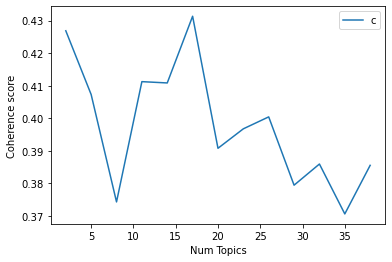

In [23]:
# Show graph
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4269
Num Topics = 5  has Coherence Value of 0.4073
Num Topics = 8  has Coherence Value of 0.3743
Num Topics = 11  has Coherence Value of 0.4112
Num Topics = 14  has Coherence Value of 0.4108
Num Topics = 17  has Coherence Value of 0.4313
Num Topics = 20  has Coherence Value of 0.3908
Num Topics = 23  has Coherence Value of 0.3967
Num Topics = 26  has Coherence Value of 0.4004
Num Topics = 29  has Coherence Value of 0.3794
Num Topics = 32  has Coherence Value of 0.3859
Num Topics = 35  has Coherence Value of 0.3706
Num Topics = 38  has Coherence Value of 0.3855


In [25]:
# Select the model and print the topics (I will choose the model with 20 topics itself.)
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.058*"share" + 0.039*"company" + 0.038*"stock" + 0.031*"rating" + '
  '0.030*"quarter" + 0.023*"price" + 0.017*"buy" + 0.017*"own" + '
  '0.016*"report" + 0.015*"average"'),
 (1,
  '0.009*"quarter" + 0.008*"year" + 0.008*"share" + 0.008*"company" + '
  '0.007*"market" + 0.007*"stock" + 0.007*"say" + 0.006*"see" + 0.006*"price" '
  '+ 0.006*"business"'),
 (2,
  '0.045*"rating" + 0.035*"company" + 0.032*"share" + 0.029*"stock" + '
  '0.028*"price" + 0.021*"report" + 0.020*"research" + 0.017*"quarter" + '
  '0.017*"ratio" + 0.016*"target"'),
 (3,
  '0.049*"share" + 0.034*"company" + 0.031*"stock" + 0.031*"rating" + '
  '0.028*"quarter" + 0.021*"price" + 0.017*"report" + 0.016*"buy" + '
  '0.016*"service" + 0.013*"average"'),
 (4,
  '0.049*"rating" + 0.041*"share" + 0.036*"company" + 0.034*"stock" + '
  '0.027*"price" + 0.024*"buy" + 0.022*"report" + 0.021*"research" + '
  '0.017*"average" + 0.016*"target"')]


In [26]:
# Finding the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9972,"share, company, stock, rating, quarter, price,...",Amarin (NASDAQ:AMRN) Rating Lowered to Strong ...
1,1,2.0,0.4387,"rating, company, share, stock, price, report, ...",Hess surges after second upgrade in two days –...
2,2,2.0,0.9950,"rating, company, share, stock, price, report, ...",Standard Chartered PLC (OTCMKTS:SCBFF) – Equit...
3,3,2.0,0.8067,"rating, company, share, stock, price, report, ...",Apergy Corp (NYSE:APY) saw some unusual option...
4,4,4.0,0.9955,"rating, share, company, stock, price, buy, rep...",WPP (LON:WPP) Stock Rating Reaffirmed by Citig...
...,...,...,...,...,...
9272,9272,4.0,0.5199,"rating, share, company, stock, price, buy, rep...",Smith & Nephew plc (NYSE:SNN) – Jefferies Fina...
9273,9273,0.0,0.9809,"share, company, stock, rating, quarter, price,...",SL Green Realty Corp (NYSE:SLG) – Equities res...
9274,9274,2.0,0.6680,"rating, company, share, stock, price, report, ...",Precision Drilling (TSE:PD) (NYSE:PDS) had its...
9275,9275,3.0,0.6332,"share, company, stock, rating, quarter, price,...",Suncor Energy (TSE:SU) (NYSE:SU) had its price...


In [27]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9982,"share, company, stock, rating, quarter, price,...",National Retail Properties (NYSE:NNN) had its ...
1,1.0,0.9999,"quarter, year, share, company, market, stock, ...",Emerson Electric Co. ( EMR ) Q2 2020 earnings ...
2,2.0,0.9978,"rating, company, share, stock, price, report, ...",Citigroup Trims Dicks Sporting Goods (NYSE:DKS...
3,3.0,0.9982,"share, company, stock, rating, quarter, price,...",Russell Investments Group Ltd. reduced its pos...
4,4.0,0.9976,"rating, share, company, stock, price, buy, rep...",Despegar.com (NYSE:DESP) Lowered to “Sell” at ...


In [77]:
# Text Summarizer of the most representative document for each topic (Using LexRank)

summary_list = []
for i in range(0,5):
    
    NUM_SENTS = 4
    summary = str()
    text = sent_topics_sorteddf_mallet['Text'][i]

    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()

    sentences = summarizer(parser.document, NUM_SENTS)  
    for sentence in sentences:
        summary += (sentence.__unicode__())
    summary_list.append(summary)    
    print(summary)
    print("")

National Retail Properties (NYSE:NNN) had its target price trimmed by Morgan Stanley from $56.00 to $34.00 in a report issued on Monday morning, BenzingaRatingsTable reports.Raymond James reduced their price objective on shares of National Retail Properties from $62.00 to $44.00 and set an outperform rating on the stock in a research note on Friday, April 17th.This represents a $2.06 dividend on an annualized basis and a dividend yield of 6.61%.Following the completion of the sale, the insider now owns 116,900 shares of the company’s stock, valued at approximately $5,026,700.

So, if you look at where we see today, you think about the percent of Automation sales, this year we’re going to be in 10% to 12% oil and gas North America.And just as Lal mentioned, certainly, as we came out of the Chinese New Year, we had some challenges in the initial days, I’ll say, but really by large we’re back to running very normally in China and as are our customers and suppliers, and so we’re hopeful th

In [92]:
# Taxonomy guided semantic similarity classifier

topic_taxonomy = {
    "executive leadership manager CEO":
    {
        "Executive Appointment":  "appointed named picked joins",
        "Executive Resignation":  "quits resigns retires departs leaves",
        "Executive Compensation": "paid compensated receives bonus payraise payout dividend"
    },
    "business company":
    {
        "Business Expansion":    "to acquire buy acquisition merge invest purchase spend subsidize win secure contract venture",
        "Business Reorganization": "bankruptcy withdraw divest exit pullout sale sell outflow writeoff split",
        "Business Partnership":  "partner team collaboration alliance deal contract",
        "Operational Outage":    "operational outage disruption halt end cancellation delay",
        "Operations Resume":     "restore restart resume maintain operations",
        "Business Statement":    "shareholder issues releases statement results policy denial confirmation",
        "Business Settlement":   "settlement refund moneyback compensate reimburse",
        "Business Competition":  "tops leads to rival competitor entrant competitive advantage",
        "Business Stakeholders": "supplier vendor provider customer client competitor competency substitute government community",
        "Industries":            "oil gas pharmaceutical retail retailer sporting banks banking financial finance real-state automotive"
    },
    "location branch plant store":
    {
        "Facility Opening":    "open expand facility",
        "Facility Relocation": "closure move shutdown relocate"
    },
    "employee worker":
    {
        "Workforce Expansion":  "jobs hiring openings recruitment looking to hire",
        "Workforce Downsizing": "job cut layoff lay off reorganization termination downsizing",
        "Workforce Discontent": "discontent dissatisfaction labor crew union strike dispute unrest boycott revolt",
        "Workforce Agreement":  "pension deal agreement contract negotiation arbitration resolve"
    },
    "marketing":
    {
        "PR Meeting":    "host presentation summit convention conference symposium meeting show exposition",
        "PR Ceremony":   "loyalty award recognize celebrity honor ceremony mark anniversary prize",
        "PR Marketing":  "advertising commercial campaign exclusive offer",
        "PR Charity":    "donate sponsor contribute benefit grant aid"
    },
    "legal"	:
    {
        "Legal Lawsuit":        "conviction guilty sue battle in court ruling sentencing class action lawsuit litigation settlement appeals trial testify",
        "Legal Investigation":  "law FBI probe allegation indictment investigation face charges grilled over",
        "Legal Scandal":        "scandal revelation whistleblower accusing accusation"
    },
    "regulation standards":
    {
        "Regulatory Impact":    "compliance safety feds audit fine debt owe penalty privacy discrimination certification government blessing taxation import duties tarriff legislation bill",
        "Environmental Regulation": "environment climate change water quality pollution emission oil spill"
    },
    "incident" :
     {
        "Financial Crime":        "insider trading activity financial crime corruption fraud bribe FCPA money laundering",
        "Crime General":          "police shot killed murder robbery burglary steal thief damage arrest kidnapping smuggling drugs cartel",
        "Security Breach":        "security data confidential information breach hacking",
        "Safety Incident":        "safety accident fire gas leak arson radiation",
        "Healthcare Casualty":    "injury death casualty ambulance healthcare epidemic hurt",
        "Automotive Emergency":   "accident car Tesla crash bus overturned",
        "Aviation Emergency":     "airplane helicopter crash landing skids off runway",
        "Violent Incident":       "war military strike killed shot terrorist attack shooting explosion bombing",
        "Natural Disaster":       "earthquake flood rainstorm snowstorm hurricane tornado"
     },
    "earnings revenue sales stock profits income":
    {
        "Revenue Growth":  "up post gain increase growth climb rise jump surge soar boost",
        "Revenue Decline": "decline down drop fall lose value decrease stumble plunge slip plummet"
    },
    "market expansion":
    {
        "New Technology":   "new technology system development invention patent driverless self-driving automation",
        "New Project":      "new project initiative field discovery exploration",
        "New Product":      "new unveil release announce launch build introduce produced concept model"

    },
    "product":
    {
        "Product Failure":  "issue problem recall citing failure withdrawal discontinue defect flaw"
    },
    "rating forecast outlook prediction rank" :
    {
        "Forecast Positive": "upgrade outperform strong growing positive optimistic high up profitable",
        "Forecast Negative": "pessimistic warn tough times decline weak negative down low downgrade fail drop"
    },
    "consumer feedback sentiment study":
    {
        "Feedback Positive": "positive best like praise upbeat success improving customer service",
        "Feedback Negative": "slam dislike complaint bad negative perception poor service harbinger stop",
        "Opinion Feedback":  "feeling question maybe opinion safe interview view blog says quote complaint comment"
    },
    "sport":
    {
        "Sport": "sports tournament match score"
    },
    "geography":
    {
        "Continent": "America Europe Asia Oceania Africa",
        "Country": "United States China Brazil Germany France Spain",
        "Region": "Northern Southern Eastern Western"
    },
    "healthcare":
    {
        "Healthcare":  "pharmaceutical clinical disease biotechnology healthcare biology therapeutic health medical disease coronavirus"
    },
    "entertainment":
    {
        "Entertainment":  "casino hospitality hotel resort entertainment"
    },
    "technology":
    {
        "Technology": "semiconductor software technology computer science innovative"
    },
    "energy":
    {
        "Energy":  "gas petroleum oil natural energy drilling chemical mineral science resource electric utility power tesla"
    },
    "food and beverage":
    {
        "Food and Beverage":  "drink beverage specialty food restaurant"
    },
    "real estate":
    {
        "Real Estate":  "property real estate land home"
    },
}

In [83]:
def load_wordvec_model(modelName, modelFile, flagBin):
    print('Loading ' + modelName + ' model...')
    model = KeyedVectors.load_word2vec_format(modelFile, binary=flagBin)
    print('Finished loading ' + modelName + ' model...')
    return model

model_word2vec = load_wordvec_model('Word2Vec', 'GoogleNews-vectors-negative300.bin.gz', True)

Loading Word2Vec model...
Finished loading Word2Vec model...


In [84]:
# function checks whether the input words are present in the vocabulary for the model
def vocab_check(vectors, words):
    
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
            
    return output

In [85]:
# Calculate semantic similarity of a pair of strings
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    
    output = vectors.n_similarity(s1words, s2words)
    return output

In [86]:
# Classify topics (run similarity of input string against taxonomy, sort and return top 3 results)
def classify_topics(input, vectors):
    feed_score = dict()
    for key, value in topic_taxonomy.items():
        max_value_score = dict()
        for label, keywords in value.items():
            max_value_score[label] = 0
            topic = (key + ' ' + keywords).strip()
            max_value_score[label] += float(calc_similarity(input, topic, vectors))
            
        sorted_max_score = sorted(max_value_score.items(), key=operator.itemgetter(1), reverse=True)[0]
        feed_score[sorted_max_score[0]] = sorted_max_score[1]
    return sorted(feed_score.items(), key=operator.itemgetter(1), reverse=True)[:3]

In [96]:
taxonomy_list = []
for i in range(0,5):
    
    output = classify_topics(sent_topics_sorteddf_mallet['Text'][i], model_word2vec)
    taxonomy_list.append(output)    
    print(output)
    

[('Revenue Growth', 0.6423572301864624), ('Forecast Positive', 0.6347085237503052), ('Business Statement', 0.6036529541015625)]
[('Feedback Negative', 0.6261606216430664), ('Forecast Negative', 0.6237407326698303), ('Revenue Growth', 0.5957316160202026)]
[('Forecast Positive', 0.6400431394577026), ('Revenue Growth', 0.6375219821929932), ('Business Statement', 0.5955312848091125)]
[('Business Statement', 0.6427571773529053), ('Revenue Growth', 0.6232601404190063), ('Forecast Positive', 0.5995251536369324)]
[('Forecast Positive', 0.6375447511672974), ('Revenue Growth', 0.6168332099914551), ('Business Statement', 0.5671156644821167)]
